# Download Data

In [72]:
import opendatasets as od
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
plt.close('all')


In [36]:
#Download the dataset
dataset_url = 'https://www.kaggle.com/jsphyg/weather-dataset-rattle-package'
od.download(dataset_url)

Skipping, found downloaded files in "./weather-dataset-rattle-package" (use force=True to force download)


In [37]:
#Read Data
df = pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv', index_col = False)
df_original = pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv', index_col = False)

In [38]:
original_column_names = df.columns

# Cleaning

In [39]:
basic_stats = df.describe()
basic_stats

MinTemp        MaxTemp       Rainfall   Evaporation  \
count  143975.000000  144199.000000  142199.000000  82670.000000   
mean       12.194034      23.221348       2.360918      5.468232   
std         6.398495       7.119049       8.478060      4.193704   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.900000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  75625.000000  135197.000000  143693.000000  142398.000000   
mean       7.611178      40.035230      14.043426      18.662657   
std        3.785483      13.607062       8.915375       8.809800   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.800000      31.000000       7.000000      13.000000   
50%        8.400000      39.000000      13.000000      19.000000   
75%       10.600000      48.000000      19.000000      24.000000   
max       14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm   Pressure9am    Pressure3pm  \
count  142806.000000  140953.000000  130395.00000  130432.000000   
mean       68.880831      51.539116    1017.64994    1015.255889   
std        19.029164      20.795902       7.10653       7.037414   
min         0.000000       0.000000     980.50000     977.100000   
25%        57.000000      37.000000    1012.90000    1010.400000   
50%        70.000000      52.000000    1017.60000    1015.200000   
75%        83.000000      66.000000    1022.40000    1020.000000   
max       100.000000     100.000000    1041.00000    1039.600000   

           Cloud9am      Cloud3pm        Temp9am       Temp3pm  
count  89572.000000  86102.000000  143693.000000  141851.00000  
mean       4.447461      4.509930      16.990631      21.68339  
std        2.887159      2.720357       6.488753       6.93665  
min        0.000000      0.000000      -7.200000      -5.40000  
25%        1.000000      2.000000      12.300000      16.60000  
50%        5.000000      5.000000      16.700000      21.10000  
75%        7.000000      7.000000      21.600000      26.40000  
max        9.000000      9.000000      40.200000      46.70000

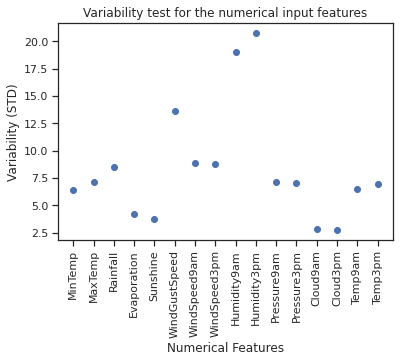

In [40]:
#plot the variablity of the data.
plt.scatter(df.select_dtypes(include=np.number).columns.tolist(), basic_stats.loc['std'])
plt.xticks(rotation=90);
plt.xlabel("Numerical Features")
plt.ylabel("Variability (STD)")
plt.title("Variability test for the numerical input features");

#### Observation: Cloud9am, Cloud3pm, Evaporation, and Sunshine have the lowest varibility. They might be good candidates for dropping if needed in the future.

In [41]:
#check for null values
def check_nulls():
    rows_size = len(df)
    null_sum = df.isnull().sum()
    null_percentage = (null_sum / rows_size) * 100
    return null_percentage
print("The current summary of null value is \n", check_nulls())

The current summary of null value is 
 Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64


Since most of the attributes have less 7% we will drop rows of the attributes that have less than 7% null values overall.

In [42]:
candidates = check_nulls() < 7
candidates = candidates[candidates]
candidates = list(candidates.index)

num_rows = len(df)
df = df.dropna(subset = candidates)
print("Dropped Percentage",((num_rows - len(df))/num_rows) * 100, "%")

Dropped Percentage 7.472844768321188 %


In [43]:
#check for null values again
print("The current summary of null values is \n", check_nulls())

The current summary of null values is 
 Date              0.000000
Location          0.000000
MinTemp           0.000000
MaxTemp           0.000000
Rainfall          0.000000
Evaporation      41.682889
Sunshine         45.957352
WindGustDir       4.468385
WindGustSpeed     4.458727
WindDir9am        5.614830
WindDir3pm        0.000000
WindSpeed9am      0.000000
WindSpeed3pm      0.000000
Humidity9am       0.000000
Humidity3pm       0.000000
Pressure9am       8.332714
Pressure3pm       8.285162
Cloud9am         37.275429
Cloud3pm         38.302994
Temp9am           0.000000
Temp3pm           0.000000
RainToday         0.000000
RainTomorrow      0.000000
dtype: float64


Notice that features that intuitively suggest a high correlation with our target variable (RainTomorrow) such as Evaporation, Sunshine, Cloud9am ,and Cloud3pm have a high precence of null values. That means that we can't really drop those columns. Also, notice the different data types and their domain.

* Evaporation |      Continuous | 0 - Inf| Replace with mean.
* Sunshine  |       Continous  | 0 - 24| Replace with mean.
* WindGustDir  |    Nominal    | TBD| Replace with mode.
* WindGustSpeed  |  Continous  | 0 - Inf| Replace with mean.
* WindDir9am    |   Nominal    | TBD| Replace with mode.
* Pressure9am | Continous |0 - Inf| Replace with mean.
* Pressure3pm | Continous | 0- Inf| Replace with mean.
* Cloud9am | Ordinal | TBD | Replace with mode.
* Cloud3pm | Ordinal | TBD | Replace with mode.

Where TBD is To Be Determined

In [44]:
candidates = check_nulls() != 0
candidates = candidates[candidates]
candidates = list(candidates.index)
fill_values = [
    df[candidates[0]].mean(),
    df[candidates[1]].mean(),
    df[candidates[2]].mode(),
    df[candidates[3]].mean(),
    df[candidates[4]].mode(),
    df[candidates[5]].mean(),
    df[candidates[6]].mean(),
    df[candidates[7]].mode(),
    df[candidates[8]].mode()
]
for i in range(len(fill_values)):
    df[candidates] = df[candidates].fillna(fill_values[i])


In [45]:
#Check for nulls one last time just to be sure...
print(check_nulls())

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64


With that, we are done with handling null values. Let's get to the real stuff :)

# EDA

In [46]:
#get categorical columns
categorical_cols = df.select_dtypes('object').columns.tolist()
print(" A summary of unique values in categorical variables \n",df[categorical_cols].nunique())
#get numerical columns
numerical_cols = list(set(df.columns) - set(categorical_cols))

 A summary of unique values in categorical variables 
 Date            3436
Location          49
WindGustDir       17
WindDir9am        17
WindDir3pm        16
RainToday          2
RainTomorrow       2
dtype: int64


In [47]:
for i in categorical_cols:
    print(i, df[i].unique())

Date ['2008-12-01' '2008-12-02' '2008-12-03' ... '2008-08-27' '2008-11-13'
 '2008-11-22']
Location ['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
WindGustDir ['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' 'ENE' 'SSE' 'S' 'NW' 'SE' 'ESE'
 'E' 'SSW' 5.468291098115681]
WindDir9am ['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' 'SSW' 'N' 'WSW' 'ESE' 'E'
 5.468291098115681 'NW' 'WNW' 'NNE']
WindDir3pm ['WNW' 'WSW' 'E' 'NW' 'W' 'SSE' 'ESE' 'ENE' 'NNW' 'SSW' 'SW' 'SE' 'N' 'S'
 '

Notice that both WindGustDir, and WindDir9am have an anomoly number.

In [48]:
anomoly = df[['WindGustDir','WindDir9am']] == 5.468291098115681
temp_sum = np.array(list(anomoly.sum())).sum()
print("The summary of the anomoly value count is \n ", anomoly.sum())
print(f"At the worst case, we'll be throwing away {temp_sum * 100/len(df)}% of the data ")

The summary of the anomoly value count is 
  WindGustDir    6014
WindDir9am     7557
dtype: int64
At the worst case, we'll be throwing away 10.08321569210194% of the data 


In [49]:
# 10% is a lot of data, so let's replace it with a new category called "dont_know"
df['WindGustDir'].replace(to_replace = 5.468291098115681,value = "dont_know", inplace=True )
df['WindDir9am'].replace(to_replace = 5.468291098115681,value = "dont_know", inplace= True )

In [50]:
for i in categorical_cols:
    print(i, df[i].unique())

Date ['2008-12-01' '2008-12-02' '2008-12-03' ... '2008-08-27' '2008-11-13'
 '2008-11-22']
Location ['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
WindGustDir ['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' 'ENE' 'SSE' 'S' 'NW' 'SE' 'ESE'
 'E' 'SSW' 'dont_know']
WindDir9am ['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' 'SSW' 'N' 'WSW' 'ESE' 'E'
 'dont_know' 'NW' 'WNW' 'NNE']
WindDir3pm ['WNW' 'WSW' 'E' 'NW' 'W' 'SSE' 'ESE' 'ENE' 'NNW' 'SSW' 'SW' 'SE' 'N' 'S'
 'NNE' 'NE']
R

Look! the weird number is gone! Also, it seems like except RainToday and RainTomorrow, everything else is nominal. Let's do label encoding for the ordinals above.

In [51]:

#Save up the mappings
label_encodings = {}
def labelEncode(_df, _col_name):
    # creating instance of labelencoder
    labelencoder = LabelEncoder()
    df = _df
    col_name = _col_name
    #fit
    labelencoder.fit(df[col_name])
    mapped_from = labelencoder.classes_
    #transform
    df[col_name] = labelencoder.transform(df[col_name])
    mapped_to = labelencoder.transform(mapped_from)
    #concat the mapping
    res = dict(zip(mapped_from, mapped_to))
    return (res, df)
mapping, df = labelEncode(df, 'RainToday')
label_encodings['RainToday'] = mapping

mapping, df = labelEncode(df, 'RainTomorrow')
label_encodings['RainTomorrow'] = mapping


In [52]:
# #apply one hot encoding to nominal features.
# ohe = OneHotEncoder()
# one_hot_encodes = ohe.fit_transform(df[categorical_cols[1:-2]]).toarray()
# one_hot_labels = np.hstack(np.array(ohe.categories_, dtype=object))
# categorical_df = pd.DataFrame(one_hot_encodes, columns=one_hot_labels)
# #let's drop a column from categorical_df to reduce multicollinearity.
# categorical_df.drop(categorical_df.columns[0], inplace = True, axis = 'columns')
# # #Let's drop the nominal columns
# df.drop(categorical_cols[1:-2],inplace= True,axis='columns')


In [53]:
df = pd.get_dummies(df, columns=categorical_cols[1:-2])

Before we concatnate the dataframes, make sure you reset the indices of both dataframes as below.

Lastly, we have to convert the date into a date number.

In [54]:
#convert to date number.
df['Date'] = pd.to_datetime(df['Date'])
# day
df['Day'] = df['Date'].dt.day
# month
df['Month'] = df['Date'].dt.month
# year
df['Year'] = df['Date'].dt.year
df.drop('Date', axis = 1, inplace = True)

Let's seperate the dependent variable from the independent variables.

In [55]:
y = pd.DataFrame(df['RainTomorrow'])
x = df.drop('RainTomorrow', axis = 1)
cols = list(x.columns)

Now, our dataset is clean. Let's try to derive insights from the processed data.

<AxesSubplot:>

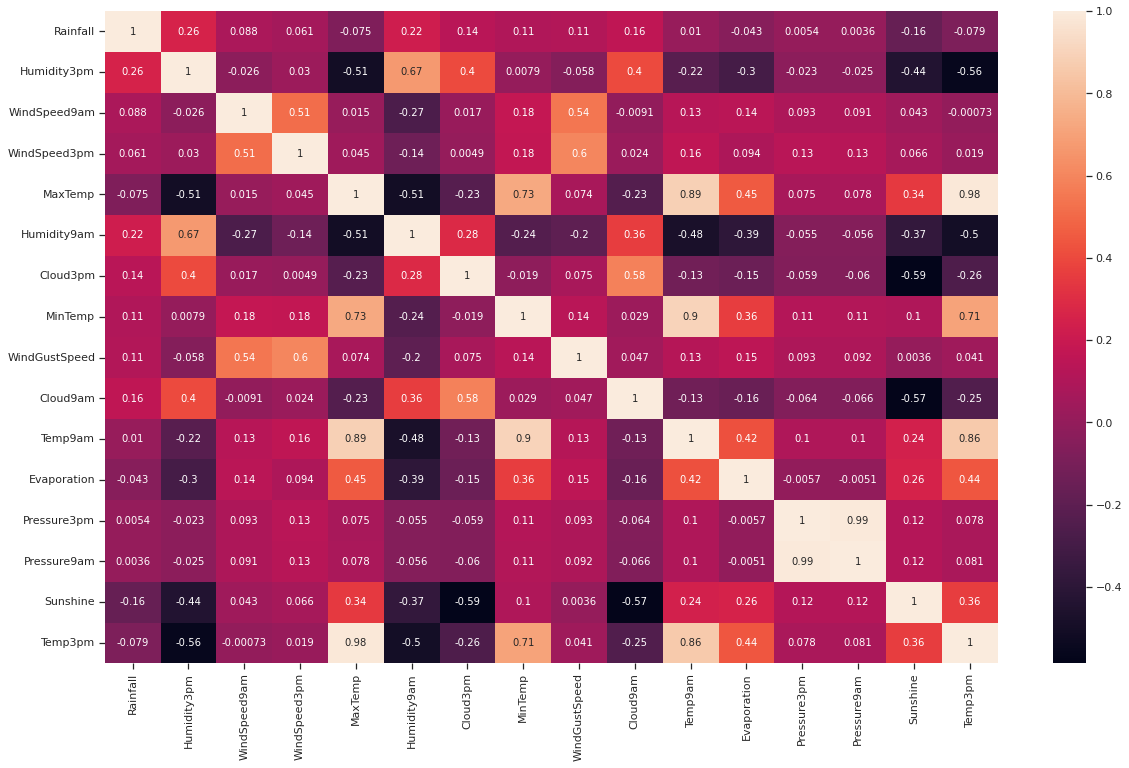

In [56]:
#Let's check which features have the highest correlation between numerical features.
%matplotlib inline
plt.figure(figsize = (20,12))
sns.heatmap(df[numerical_cols].corr(), annot=True)



#### Observation: During the experiment, some of the measurements have been taken twice a day, along with their max and min values. However, most of them seem to very high correlations which makes them good candidates for feature dropping. At this point, we are convinced that picking a single feature from each type of measurement (i.e.temperature, pressure etc) might give us a parsimonious model. We can easily identify those candidates by setting up the threshold of the correlation to 0.5. Although positive correlations could go close to 1, negative correlations have stucked around 0.5 at the worst case.

In [57]:
print(df['RainTomorrow'])

0         0
1         0
2         0
3         0
4         0
         ..
145454    0
145455    0
145456    0
145457    0
145458    0
Name: RainTomorrow, Length: 134590, dtype: int64


/tmp/ipykernel_35885/2321542913.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['RainTomorrow'] = df['RainTomorrow']


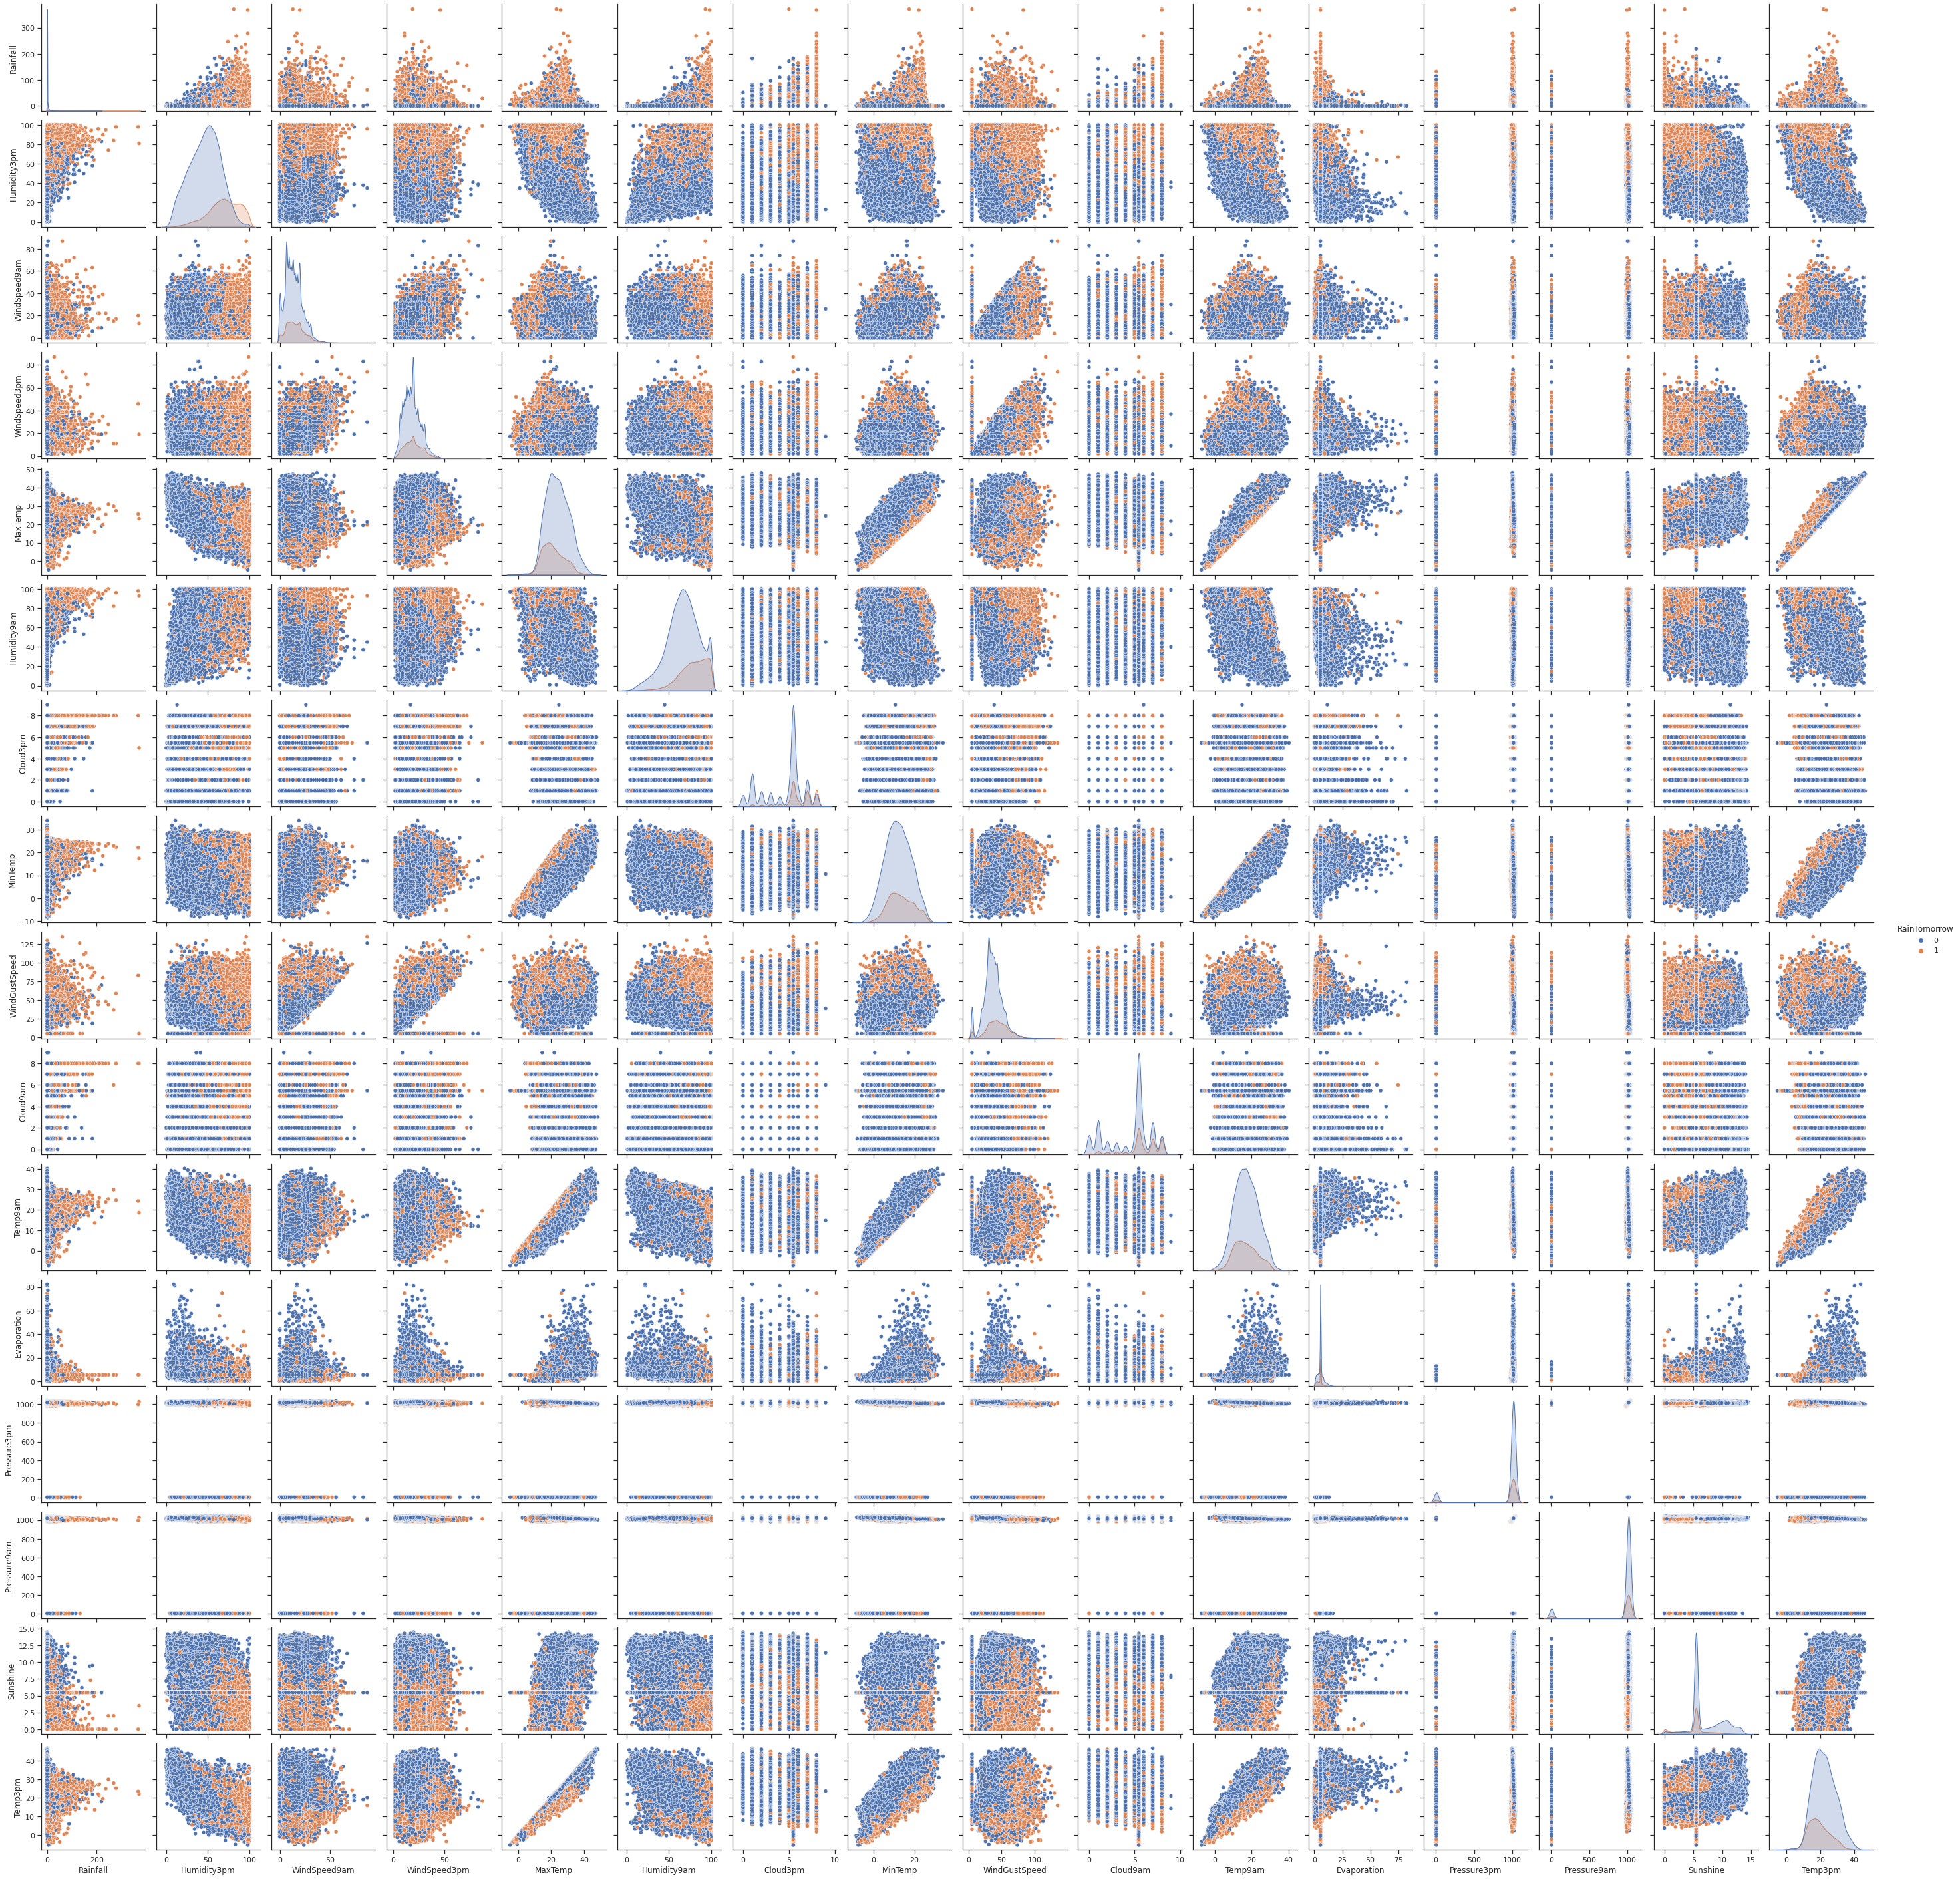

In [58]:
#Further looking at the correlations...
%matplotlib inline
sns.set(style="ticks", color_codes=True)
temp_df = df[numerical_cols]
temp_df['RainTomorrow'] = df['RainTomorrow']
sns.pairplot(temp_df, hue = 'RainTomorrow').savefig("pairplot.png")
plt.show()

By looking at the pairplot, we don't see a huge outlier problem. So, we are good there. Also, we can verify our above observation here. Next, we are going to look at the correlation between categorical variables using Chi Squared Test/ Fisher Test. Recall that the Fisher test gives two things; f score and p value. Higher the f score value is the better and lower the p value is better in our scenario.

In [59]:
#First, we have to update the categorical columns
categorical_cols = list(set(x.columns) - set(numerical_cols))

In [60]:
x[categorical_cols].astype(int)
y.astype(int)
f_scores, p_values = chi2(x[categorical_cols],y)

In [61]:
# f_scores = list(f_scores)
# p_values = list(p_values)
f_scores[0]


60.22879926956333

In [62]:
f_scores = dict(zip(categorical_cols,f_scores))
f_scores = OrderedDict(sorted(f_scores.items(), key=lambda kv:
                 (kv[1], kv[0]), reverse=True))


In [63]:
p_values = dict(zip(categorical_cols,p_values))
p_values = OrderedDict(sorted(p_values.items(), key=lambda kv:
                 (kv[1], kv[0])))

Let's look at the top of five categorical features.

In [64]:
temp_f_labels = list(f_scores.keys())
temp_p_labels = list(p_values.keys())
num_features = 5
for i in range(num_features):
    print("Fisher Score: ",temp_f_labels[i],"=>>", f_scores[temp_f_labels[i]])
    print("P-value: ", temp_p_labels[i],"=>>", p_values[temp_p_labels[i]])

Fisher Score:  RainToday =>> 10133.108059274187
P-value:  RainToday =>> 0.0
Fisher Score:  WindDir9am_N =>> 458.69356566646474
P-value:  WindDir9am_N =>> 9.251130534690684e-102
Fisher Score:  Location_Woomera =>> 399.39296606677163
P-value:  Location_Woomera =>> 7.465837898211612e-89
Fisher Score:  Location_Portland =>> 351.29422123990054
P-value:  Location_Portland =>> 2.214654897130482e-78
Fisher Score:  Location_AliceSprings =>> 347.7860358239526
P-value:  Location_AliceSprings =>> 1.2860740692813105e-77


#### Observation: RainToday is the most promising categorical feature.
Now, let's look at the worst 5 features.

In [65]:
for i in range(-1, -num_features, -1):
    print("Fisher Score: ",temp_f_labels[i],"=>>", f_scores[temp_f_labels[i]])
    print("P-value: ", temp_p_labels[i],"=>>", p_values[temp_p_labels[i]])

Fisher Score:  WindDir3pm_SSW =>> 0.012739092266100364
P-value:  WindDir3pm_SSW =>> 0.9101355336632813
Fisher Score:  Location_MelbourneAirport =>> 0.05833113183382097
P-value:  Location_MelbourneAirport =>> 0.8091533665256261
Fisher Score:  Year =>> 0.08705571201459585
P-value:  Year =>> 0.7679541186913098
Fisher Score:  WindDir3pm_WSW =>> 0.10181339601368405
P-value:  WindDir3pm_WSW =>> 0.7496642456406848


#### Observation: It seems that Year is not a very significant categorical feature.

Now, we will plot nominal features against the dependent variable.

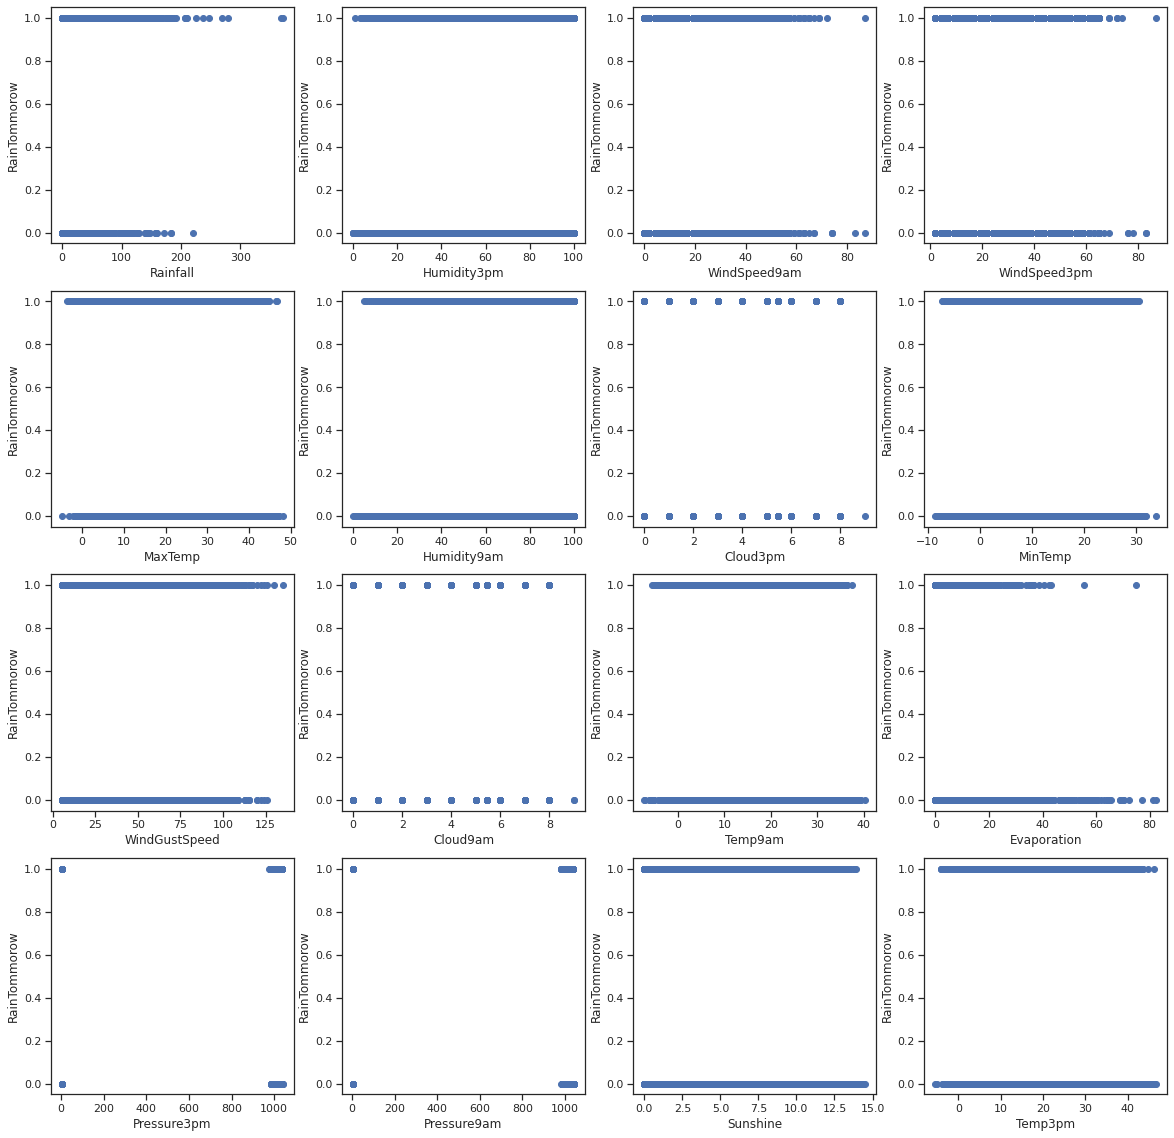

In [66]:
plt.figure(figsize=(20, 20))
plt.subplot(4,4, 1)
for i in range(1, len(numerical_cols) + 1):
    plt.subplot(4,4,i)
    plt.scatter(df[numerical_cols[i - 1]].to_list(), y['RainTomorrow'].to_list())
    plt.xlabel(numerical_cols[i - 1])
    plt.ylabel("RainTommorow")

# Feature Scaling

We'll standardize the features here.

In [67]:
norm = StandardScaler().fit(x)
x  = norm.transform(x)
x = pd.DataFrame(x, columns=cols)

# Building the Initial Model

First step would be to split the data into train and test.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=40)

Just by looking at the pair plot above, we can see that we could draw a linear decision boundary using linear regression for most of the numerical features. We will try adding non-linearity to the decsion boundary as well as trying out other models.

In [69]:
model = LogisticRegression(random_state=0).fit(X_train, y_train)

/home/kjayamanna/anaconda3/envs/rainPred/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [73]:
y_preds = model.predict(X_test)

In [76]:
accuracy = model.score(X_test, y_test)

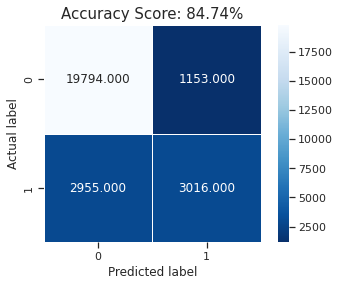

In [81]:
#Derive the confusion matrix
cm = metrics.confusion_matrix(y_test, y_preds)
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}%'.format(round(accuracy*100, 2))
plt.title(all_sample_title, size = 15);
TN, FP, FN, TP = cm.ravel()

In [82]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [96]:
print(" TPR = " + str(round(TPR * 100, 2)) + "%"+ " TNR = " + str(round(TNR * 100, 2)) + "%" + " PPV = " +  str(round(PPV * 100, 2)) + "%" + " Accuracy = " + str(round(ACC * 100, 2)) + "%")

 TPR = 50.51% TNR = 94.5% PPV = 72.34% Accuracy = 84.74%


Observe that the true positive rate is quite low compared to true negative rate. That indicates that the dataset might have some class imbalance.

In [110]:
positive_cases = (y==1.0)
positive_cases = positive_cases.sum()[0]
negative_cases = len(y) - positive_cases
print("Positive Percentage = ",positive_cases*100/len(y), "%")
print("Negative Percentage = ",negative_cases*100/len(y), "%")

Positive Percentage =  21.958540753399213 %
Negative Percentage =  78.0414592466008 %


The class if imbalance is huge!!! Almost 4X. Let's mitigate it's effects.

#### Handling data Imbalance

# References
* https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
